In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import dlib
import itertools
from skimage.draw import polygon

In [11]:
clinton = cv2.imread("bud1.jpg",cv2.IMREAD_COLOR) #image 1
obama = cv2.imread("flower1.jpg",cv2.IMREAD_COLOR)     #image 2

In [13]:
s =int(input('ENTER 1  for PART A and 2 for PART B '))

array_of_images=[]

if (s==1):
    num_of_frames = int(input('Enter the number of intermediate images to be used:'))
    
    f = open("input1.txt", "r")
    c=0
    tie_list=[]
    tie_list1=[]

    f.readline()
    for l in f.readlines():
            arr = l.split(' ')
            x=(float(arr[0]),float(arr[1]))
            y=(float(arr[2]),float(arr[3]))
            tie_list.append(x)
            tie_list1.append(y)
    
    for i in range (num_of_frames):
        p = i/(num_of_frames-1)
 
        size = obama.shape   
        #adding four corner points of frame as tie points in image 1
        tie_list.append((0,0))     
        tie_list.append((0,size[0]-1))
        tie_list.append((size[1]-1,0))
        tie_list.append((size[1]-1,size[0]-1))

            #adding four corner points of frame as tie points in image 2
        tie_list1.append((0,0))
        tie_list1.append((0,size[0]-1))
        tie_list1.append((size[1]-1,0))
        tie_list1.append((size[1]-1,size[0]-1))
            
        rect1 = (0, 0, size[1], size[0])
        rect2 = (0, 0, size[1], size[0])

        #creating subdiv instance for triangulation
        subdiv1 = cv2.Subdiv2D(rect1)
        subdiv2 = cv2.Subdiv2D(rect2)

        #inserting tie points in subdiv
        for point in tie_list:
            subdiv1.insert(point)

        for points in tie_list1:
            subdiv2.insert(points)

        #dictionary for tracking the indices of corresponding tie points in image 1 and image 2
        index_dict = {}
        index_dict1= {}

        index=0 
        for key in tie_list:
            index_dict[key]=index
            index+=1
        ind =0 
        for key in tie_list1:
            index_dict1[key]=ind
            ind+=1

        #getting the triangle list from subdiv
        triangle_list = subdiv1.getTriangleList()
        triangle_list_1 = subdiv2.getTriangleList()

        key_list = list(index_dict.keys())
        val_list = list(index_dict.values())

        warp_intermediate =np.zeros(size) 

        for t in triangle_list_1:
            t_points = []
            pt1 = key_list[val_list.index(index_dict1[(t[0],t[1])])]
            pt2 = key_list[val_list.index(index_dict1[(t[2],t[3])])]
            pt3 = key_list[val_list.index(index_dict1[(t[4],t[5])])]
            t_points.append(pt1[0]*p+(1-p)*t[0])
            t_points.append(pt1[1]*p+(1-p)*t[1])
            t_points.append(pt2[0]*p+(1-p)*t[2])
            t_points.append(pt2[1]*p+(1-p)*t[3])
            t_points.append(pt3[0]*p+(1-p)*t[4])
            t_points.append(pt3[1]*p+(1-p)*t[5])
            t1 = [pt1[0],pt1[1],pt2[0],pt2[1],pt3[0],pt3[1]]

            # corresponding triangles in intermediate,image 1 and image 2 i.e. a,b,c

            a=[(t_points[0],t_points[1]),(t_points[2],t_points[3]),(t_points[4],t_points[5])] 
            b=[(t[0],t[1]),(t[2],t[3]),(t[4],t[5])]                                             
            c=[(t1[0],t1[1]),(t1[2],t1[3]),(t1[4],t1[5])]                                     

            #bounding rectangle for corresponding triangles in img1,intermediate,img2
            rectangle_1 = cv2.boundingRect(np.float32([b])) 
            rectangle_2 = cv2.boundingRect(np.float32([c]))  
            rectangle = cv2.boundingRect(np.float32([a]))  

            #calculating coordinates of points corresponding to the bounding rectangle's top left corner(i.e. its start)
            off_Rect1 = []
            off_Rect2 = []
            off_Rect = []

            for poi in range (3):
                off_Rect.append(((a[poi][0] - rectangle[0]),(a[poi][1] - rectangle[1])))
                off_Rect1.append(((b[poi][0] - rectangle_1[0]),(b[poi][1] - rectangle_1[1])))
                off_Rect2.append(((c[poi][0] - rectangle_2[0]),(c[poi][1] - rectangle_2[1])))

            #Creating a mask of size of rectangle
            mask = np.zeros((rectangle[3], rectangle[2], 3), dtype = np.float32)
            cv2.fillConvexPoly(mask, np.int32(off_Rect), (1.0, 1.0, 1.0), 16, 0)

            #Cropping the part of image containing the rectangle for applying affine transformation
            image1 = clinton[rectangle_1[1]:rectangle_1[1] + rectangle_1[3], rectangle_1[0]:rectangle_1[0] + rectangle_1[2]]
            image2 = obama[rectangle_2[1]:rectangle_2[1] + rectangle_2[3], rectangle_2[0]:rectangle_2[0] + rectangle_2[2]]

            #size of mask
            s = (rectangle[2], rectangle[3])

            #applying affine transformation from triangle in image 1 to intermediate image
            Affine1 = cv2.getAffineTransform(np.float32(off_Rect1), np.float32(off_Rect))

            warp1 = cv2.warpAffine(image1, Affine1, (s[0], s[1]), None, flags=cv2.INTER_LINEAR)


            #applying affine transformation from triangle in image 2 to intermediate image
            Affine2 = cv2.getAffineTransform(np.float32(off_Rect2), np.float32(off_Rect))

            warp2 = cv2.warpAffine(image2, Affine2, (s[0], s[1]), None, flags=cv2.INTER_LINEAR)

            #cross dissolving the two images
            image = (1.0 - p) * warp1 + p * warp2

            #add the traingle obtained from affine transform and cross dissolve to the intermediate image  
            warp_intermediate[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] = warp_intermediate[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] * ( 1 - mask ) + image * mask  

        warp_intermediate_rgb = np.uint8(warp_intermediate)
        array_of_images.append(warp_intermediate_rgb)
            
            
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter('bud2flower1.mp4',fourcc, 20, (obama.shape[1],obama.shape[0]))
        for i in range(len(array_of_images)):
            out.write(array_of_images[i])
        out.release()

elif (s==2):
    num_of_frames = int(input('Enter the number of intermediate images to be used:'))

    for i in range (num_of_frames):
            p = i/(num_of_frames-1)

            detector = dlib.get_frontal_face_detector()
            predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

            face2 = detector(clinton,0) #detecting face in image 1 
            face = detector(obama, 0)   #detecting face in image 2

            my_face = face[0]          #face in image 1
            my_face_new = face2[0]     #face in image 2 

            tie_points = predictor(obama, my_face)   #generating tie points of image 1
            tie_list = []

            tie_points1 = predictor(clinton,my_face_new)  #generating tie points of image 2
            tie_list1 = []

            for i in range (0, tie_points.num_parts):    
                tie_list.append((tie_points.part(i).x, tie_points.part(i).y))

            for j in range (0, tie_points1.num_parts):
                tie_list1.append((tie_points1.part(j).x, tie_points1.part(j).y))
            
            size = obama.shape
            #adding four corner points of frame as tie points in image 1
            tie_list.append((0,0))     
            tie_list.append((0,size[0]-1))
            tie_list.append((size[1]-1,0))
            tie_list.append((size[1]-1,size[0]-1))

            #adding four corner points of frame as tie points in image 2
            tie_list1.append((0,0))
            tie_list1.append((0,size[0]-1))
            tie_list1.append((size[1]-1,0))
            tie_list1.append((size[1]-1,size[0]-1))

               
            
            rect1 = (0, 0, size[1], size[0])
            rect2 = (0, 0, size[1], size[0])

            #creating subdiv instance for triangulation
            subdiv1 = cv2.Subdiv2D(rect1)
            subdiv2 = cv2.Subdiv2D(rect2)

            #inserting tie points in subdiv
            for point in tie_list:
                subdiv1.insert(point)

            for points in tie_list1:
                subdiv2.insert(points)


            #dictionary for tracking the indices of corresponding tie points in image 1 and image 2
            index_dict = {}
            index_dict1= {}

            index=0 
            for key in tie_list:
                index_dict[key]=index
                index+=1
            ind =0 
            for key in tie_list1:
                index_dict1[key]=ind
                ind+=1

            #getting the triangle list from subdiv
            triangle_list = subdiv1.getTriangleList()
            triangle_list_1 = subdiv2.getTriangleList()

            key_list = list(index_dict.keys())
            val_list = list(index_dict.values())

            warp_intermediate =np.zeros(size) 

            for t in triangle_list_1:
                t_points = []
                pt1 = key_list[val_list.index(index_dict1[(t[0],t[1])])]
                pt2 = key_list[val_list.index(index_dict1[(t[2],t[3])])]
                pt3 = key_list[val_list.index(index_dict1[(t[4],t[5])])]
                t_points.append(pt1[0]*p+(1-p)*t[0])
                t_points.append(pt1[1]*p+(1-p)*t[1])
                t_points.append(pt2[0]*p+(1-p)*t[2])
                t_points.append(pt2[1]*p+(1-p)*t[3])
                t_points.append(pt3[0]*p+(1-p)*t[4])
                t_points.append(pt3[1]*p+(1-p)*t[5])
                t1 = [pt1[0],pt1[1],pt2[0],pt2[1],pt3[0],pt3[1]]

                # corresponding triangles in intermediate,image 1 and image 2 i.e. a,b,c

                a=[(t_points[0],t_points[1]),(t_points[2],t_points[3]),(t_points[4],t_points[5])] 
                b=[(t[0],t[1]),(t[2],t[3]),(t[4],t[5])]                                             
                c=[(t1[0],t1[1]),(t1[2],t1[3]),(t1[4],t1[5])]                                     

                #bounding rectangle for corresponding triangles in img1,intermediate,img2
                rectangle_1 = cv2.boundingRect(np.float32([b])) 
                rectangle_2 = cv2.boundingRect(np.float32([c]))  
                rectangle = cv2.boundingRect(np.float32([a]))  

                #calculating coordinates of points corresponding to the bounding rectangle's top left corner(i.e. its start)
                off_Rect1 = []
                off_Rect2 = []
                off_Rect = []

                for poi in range (3):
                    off_Rect.append(((a[poi][0] - rectangle[0]),(a[poi][1] - rectangle[1])))
                    off_Rect1.append(((b[poi][0] - rectangle_1[0]),(b[poi][1] - rectangle_1[1])))
                    off_Rect2.append(((c[poi][0] - rectangle_2[0]),(c[poi][1] - rectangle_2[1])))

                #Creating a mask of size of rectangle
                mask = np.zeros((rectangle[3], rectangle[2], 3), dtype = np.float32)
                cv2.fillConvexPoly(mask, np.int32(off_Rect), (1.0, 1.0, 1.0), 16, 0)

                #Cropping the part of image containing the rectangle for applying affine transformation
                image1 = clinton[rectangle_1[1]:rectangle_1[1] + rectangle_1[3], rectangle_1[0]:rectangle_1[0] + rectangle_1[2]]
                image2 = obama[rectangle_2[1]:rectangle_2[1] + rectangle_2[3], rectangle_2[0]:rectangle_2[0] + rectangle_2[2]]

                #size of mask
                s = (rectangle[2], rectangle[3])

                #applying affine transformation from triangle in image 1 to intermediate image
                Affine1 = cv2.getAffineTransform(np.float32(off_Rect1), np.float32(off_Rect))

                warp1 = cv2.warpAffine(image1, Affine1, (s[0], s[1]), None, flags=cv2.INTER_LINEAR)


                #applying affine transformation from triangle in image 2 to intermediate image
                Affine2 = cv2.getAffineTransform(np.float32(off_Rect2), np.float32(off_Rect))

                warp2 = cv2.warpAffine(image2, Affine2, (s[0], s[1]), None, flags=cv2.INTER_LINEAR)

                #cross dissolving the two images
                image = (1.0 - p) * warp1 + p * warp2

                #add the traingle obtained from affine transform and cross dissolve to the intermediate image  
                warp_intermediate[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] = warp_intermediate[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] * ( 1 - mask ) + image * mask  
            
            warp_intermediate_rgb = np.uint8(warp_intermediate)
            array_of_images.append(warp_intermediate_rgb)
            
            
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter('clinton2obama.mp4',fourcc, 20, (obama.shape[1],obama.shape[0]))
            for i in range(len(array_of_images)):
                out.write(array_of_images[i])
            out.release()


ENTER 1  for PART A and 2 for PART B 1
Enter the number of intermediate images to be used:80



Note: you may need to restart the kernel to use updated packages.



CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/main/noarch/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

If your current network has https://www.anaconda.com blocked, please file
a support request with your network engineering team.

'https//repo.anaconda.com/pkgs/main/noarch'




[1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 6 6 7 8]
[1 2 3 4 5 6 7 2 3 4 5 6 3 4 5 6 3 4 5 4 5 4 4]
1d1
2d2
2d3
2d4
2d5
2d6
2d7
3d2
3d3
3d4
3d5
3d6
4d3
4d4
4d5
4d6
5d3
5d4
5d5
6d4
6d5
7d4
8d4


SyntaxError: invalid syntax (3235888368.py, line 1)

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Shubhada\miniconda3

  added / updated specs:
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libzopfli-1.0.3            |       ha925a31_0         176 KB
    ------------------------------------------------------------
                                           Total:         176 KB

The following NEW packages will be INSTALLED:

  appdirs            pkgs/main/noarch::appdirs-1.4.4-pyhd3eb1b0_0 
  blosc              pkgs/main/win-64::blosc-1.21.3-h6c2663c_0 
  cfitsio            pkgs/main/win-64::cfitsio-3.470-h2bbff1b_7 
  charls             pkgs/main/win-64::charls-2.2.0-h6c2663c_0 
  cloudpickle        pkgs/main/noarch::cloudpickle-2.0.0-pyhd3eb1b0_0 
  cytoolz            pkgs/main/win-64::cytoolz-0.12.0-py310h2bbff1b_0 
  dask-core          pkgs/main/win-64::dask-core-2


Note: you may need to restart the kernel to use updated packages.


(705, 564, 3)


Text(0.5, 1.0, 'OBAMA')

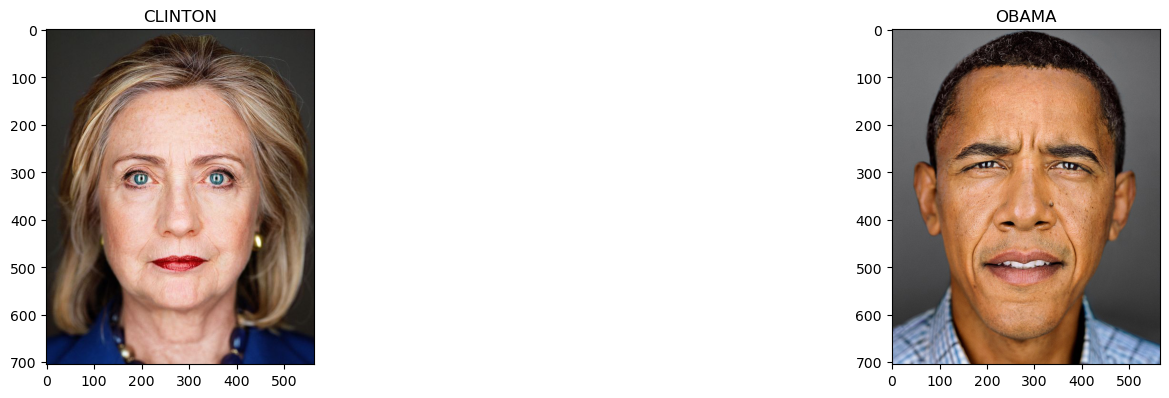

In [29]:
# clinton = cv2.imread("clinton.jpg",cv2.IMREAD_COLOR)
# obama = cv2.imread("obama.jpg",cv2.IMREAD_COLOR)

# print(obama.shape)
# clinton_rgb = clinton[:,:,::-1] 

# obama_rgb = obama[:,:,::-1] 

# plt.figure(figsize=[20,20])
# plt.subplot(4,2,1);plt.imshow(clinton_rgb);plt.title("CLINTON")
# plt.subplot(4,2,2);plt.imshow(obama_rgb);plt.title("OBAMA")





In [ ]:
elif (s==2):
    clinton = cv2.imread("clinton.jpg",cv2.IMREAD_COLOR) #image 1
    obama = cv2.imread("obama.jpg",cv2.IMREAD_COLOR)     #image 2

    num_of_frames = int(input('Enter the number of intermediate images to be used:'))

    
    
    
    for i in range (num_of_frames):
            p = i/(num_of_frames-1)

            detector = dlib.get_frontal_face_detector()
            predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

            face2 = detector(clinton,0) #detecting face in image 1 
            face = detector(obama, 0)   #detecting face in image 2

            my_face = face[0]          #face in image 1
            my_face_new = face2[0]     #face in image 2 

            tie_points = predictor(obama, my_face)   #generating tie points of image 1
            tie_list = []

            tie_points1 = predictor(clinton,my_face_new)  #generating tie points of image 2
            tie_list1 = []

            for i in range (0, tie_points.num_parts):    
                tie_list.append((tie_points.part(i).x, tie_points.part(i).y))

            for j in range (0, tie_points1.num_parts):
                tie_list1.append((tie_points1.part(j).x, tie_points1.part(j).y))

            #adding four corner points of frame as tie points in image 1
            tie_list.append((0,0))     
            tie_list.append((0,704))
            tie_list.append((563,0))
            tie_list.append((563,704))

            #adding four corner points of frame as tie points in image 2
            tie_list1.append((0,0))
            tie_list1.append((0,704))
            tie_list1.append((563,0))
            tie_list1.append((563,704))

            print(tie_list)
            size = obama.shape   

            rect1 = (0, 0, size[1], size[0])
            rect2 = (0, 0, size[1], size[0])

            #creating subdiv instance for triangulation
            subdiv1 = cv2.Subdiv2D(rect1)
            subdiv2 = cv2.Subdiv2D(rect2)

            #inserting tie points in subdiv
            for point in tie_list:
                subdiv1.insert(point)

            for points in tie_list1:
                subdiv2.insert(points)


            #dictionary for tracking the indices of corresponding tie points in image 1 and image 2
            index_dict = {}
            index_dict1= {}

            index=0 
            for key in tie_list:
                index_dict[key]=index
                index+=1
            ind =0 
            for key in tie_list1:
                index_dict1[key]=ind
                ind+=1

            #getting the triangle list from subdiv
            triangle_list = subdiv1.getTriangleList()
            triangle_list_1 = subdiv2.getTriangleList()

            key_list = list(index_dict.keys())
            val_list = list(index_dict.values())

            warp_intermediate =np.zeros(size) 

            for t in triangle_list_1:
                t_points = []
                pt1 = key_list[val_list.index(index_dict1[(t[0],t[1])])]
                pt2 = key_list[val_list.index(index_dict1[(t[2],t[3])])]
                pt3 = key_list[val_list.index(index_dict1[(t[4],t[5])])]
                t_points.append(pt1[0]*p+(1-p)*t[0])
                t_points.append(pt1[1]*p+(1-p)*t[1])
                t_points.append(pt2[0]*p+(1-p)*t[2])
                t_points.append(pt2[1]*p+(1-p)*t[3])
                t_points.append(pt3[0]*p+(1-p)*t[4])
                t_points.append(pt3[1]*p+(1-p)*t[5])
                t1 = [pt1[0],pt1[1],pt2[0],pt2[1],pt3[0],pt3[1]]

                # corresponding triangles in intermediate,image 1 and image 2 i.e. a,b,c

                a=[(t_points[0],t_points[1]),(t_points[2],t_points[3]),(t_points[4],t_points[5])] 
                b=[(t[0],t[1]),(t[2],t[3]),(t[4],t[5])]                                             
                c=[(t1[0],t1[1]),(t1[2],t1[3]),(t1[4],t1[5])]                                     

                #bounding rectangle for corresponding triangles in img1,intermediate,img2
                rectangle_1 = cv2.boundingRect(np.float32([b])) 
                rectangle_2 = cv2.boundingRect(np.float32([c]))  
                rectangle = cv2.boundingRect(np.float32([a]))  

                #calculating coordinates of points corresponding to the bounding rectangle's top left corner(i.e. its start)
                off_Rect1 = []
                off_Rect2 = []
                off_Rect = []

                for poi in range (3):
                    off_Rect.append(((a[poi][0] - rectangle[0]),(a[poi][1] - rectangle[1])))
                    off_Rect1.append(((b[poi][0] - rectangle_1[0]),(b[poi][1] - rectangle_1[1])))
                    off_Rect2.append(((c[poi][0] - rectangle_2[0]),(c[poi][1] - rectangle_2[1])))

                #Creating a mask of size of rectangle
                mask = np.zeros((rectangle[3], rectangle[2], 3), dtype = np.float32)
                cv2.fillConvexPoly(mask, np.int32(off_Rect), (1.0, 1.0, 1.0), 16, 0)

                #Cropping the part of image containing the rectangle for applying affine transformation
                image1 = clinton[rectangle_1[1]:rectangle_1[1] + rectangle_1[3], rectangle_1[0]:rectangle_1[0] + rectangle_1[2]]
                image2 = obama[rectangle_2[1]:rectangle_2[1] + rectangle_2[3], rectangle_2[0]:rectangle_2[0] + rectangle_2[2]]

                #size of mask
                s = (rectangle[2], rectangle[3])

                #applying affine transformation from triangle in image 1 to intermediate image
                Affine1 = cv2.getAffineTransform(np.float32(off_Rect1), np.float32(off_Rect))

                warp1 = cv2.warpAffine(image1, Affine1, (s[0], s[1]), None, flags=cv2.INTER_LINEAR)


                #applying affine transformation from triangle in image 2 to intermediate image
                Affine2 = cv2.getAffineTransform(np.float32(off_Rect2), np.float32(off_Rect))

                warp2 = cv2.warpAffine(image2, Affine2, (s[0], s[1]), None, flags=cv2.INTER_LINEAR)

                #cross dissolving the two images
                image = (1.0 - p) * warp1 + p * warp2

                #add the traingle obtained from affine transform and cross dissolve to the intermediate image  
                warp_intermediate[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] = warp_intermediate[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] * ( 1 - mask ) + image * mask  


            warp_intermediate_rgb =  warp_intermediate[:,:,::-1]
            plt.figure(figsize=[20,20])
            plt.subplot(10,1,1);plt.imshow(warp_intermediate_rgb.astype(np.uint8));plt.title("Warped")



In [ ]:
conda install -c conda-forge dlib
conda config --set ssl_verify no

In [4]:
import cv2

# define a function to display the coordinates of

# of the points clicked on the image
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'({x},{y})')
      
      # put coordinates as text on the image
        cv2.putText(img, f'({x},{y})',(x,y),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      
      # draw point on the image
        cv2.circle(img, (x,y), 3, (0,255,255), -1)
 
# read the input image
img = cv2.imread("flower1.jpg",cv2.IMREAD_COLOR)

# create a window
cv2.namedWindow('Point Coordinates')

# bind the callback function to window
cv2.setMouseCallback('Point Coordinates', click_event)

# display the image
while True:
    cv2.imshow("Point Coordinates",img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

(135,477)
(135,456)
(141,436)
(145,420)
(147,405)
(152,390)
(154,376)
(158,360)
(160,342)
(165,324)
(167,306)
(174,287)
(178,266)
(183,242)
(188,222)
(191,204)
(193,184)
(32,397)
(101,360)
(172,180)
(149,177)
(137,166)
(128,148)
(124,127)
(136,107)
(150,98)
(175,94)
(194,96)
(210,95)
(227,102)
(242,113)
(248,125)
(255,140)
(258,152)
(257,173)
(248,184)
(233,190)


In [7]:
import cv2

# define a function to display the coordinates of

# of the points clicked on the image
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'({x},{y})')
      
      # put coordinates as text on the image
        cv2.putText(img, f'({x},{y})',(x,y),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      
      # draw point on the image
        cv2.circle(img, (x,y), 3, (0,255,255), -1)
 
# read the input image
img = cv2.imread("bud1.jpg",cv2.IMREAD_COLOR)

# create a window
cv2.namedWindow('Point Coordinates')

# bind the callback function to window
cv2.setMouseCallback('Point Coordinates', click_event)

# display the image
while True:
    cv2.imshow("Point Coordinates",img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

(220,498)
(219,484)
(220,471)
(220,460)
(220,447)
(220,433)
(220,420)
(221,409)
(221,396)
(223,383)
(223,373)
(223,358)
(223,347)
(225,336)
(225,326)
(225,317)
(228,310)
(36,312)
(155,305)
(223,304)
(219,299)
(214,292)
(212,283)
(212,273)
(216,266)
(224,263)
(230,256)
(239,256)
(252,257)
(255,261)
(259,267)
(261,274)
(263,282)
(260,290)
(255,296)
(250,303)
(239,307)
